In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [4]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 5 # number of HPO iterations for final modeling run

In [5]:
if not os.path.exists("brca_metabric_processed"):
    !wget -O brca_metabric.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/brca_metabric_processed.tgz" && tar -xzvf brca_metabric.tgz

--2025-03-11 21:40:11--  https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/brca_metabric_processed.tgz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.46, 141.80.181.47
connected. to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.46|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 407225158 (388M) [application/octet-stream]
Saving to: ‘brca_metabric.tgz’

brca_metabric.tgz   100%[===================>] 388.36M   165MB/s    in 2.4s    

2025-03-11 21:40:14 (165 MB/s) - ‘brca_metabric.tgz’ saved [407225158/407225158]

brca_metabric_processed/
brca_metabric_processed/test/
brca_metabric_processed/test/gex.csv
brca_metabric_processed/test/mut.csv
brca_metabric_processed/test/clin.csv
brca_metabric_processed/test/cna.csv
brca_metabric_processed/9606.protein.aliases.v12.0.txt.gz
brca_metabric_processed/9606.protein.links.v12.0.txt.gz
brca_metabric_processed/train/
brca_metabric_processed/train/gex.csv
br

In [6]:
# train data
!wc -l ./brca_metabric_processed/train/*

     1307 ./brca_metabric_processed/train/clin.csv
    22543 ./brca_metabric_processed/train/cna.csv
    20604 ./brca_metabric_processed/train/gex.csv
      174 ./brca_metabric_processed/train/mut.csv
    44628 total


In [7]:
# test data
!wc -l ./brca_metabric_processed/test/* 

      561 ./brca_metabric_processed/test/clin.csv
    22543 ./brca_metabric_processed/test/cna.csv
    20604 ./brca_metabric_processed/test/gex.csv
      174 ./brca_metabric_processed/test/mut.csv
    43882 total


In [8]:
data_importer = flexynesis.DataImporter(path ='./brca_metabric_processed/', 
                                        data_types = ['gex', 'cna'], 
                                        concatenate=False, 
                                        top_percentile=10, 
                                        min_features=100, 
                                        variance_threshold=0.8, # set to 0.8 for 80%   
                                       )
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/train/cna.csv...
[INFO] Importing ./brca_metabric_processed/train/gex.csv...
[INFO] Importing ./brca_metabric_processed/train/clin.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./brca_metabric_processed/test/cna.csv...
[INFO] Importing ./brca_metabric_processed/test/gex.csv...
[INFO] Importing ./brca_metabric_processed/test/clin.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 7  # of rows: 5
[INFO] Number of NA value

Filtering redundant features: 100%|██████████| 412/412 [00:00<00:00, 9437.96it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  4509 features  and  1303  samples 


Filtering redundant features: 100%|██████████| 450/450 [00:00<00:00, 388681.38it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 16482 features.

[INFO] working on layer:  cna
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 63  # of rows: 51
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 18033 features.
[INFO] DataFrame gex - Removed 2 samples (0.36%).
[INFO] DataFrame cna - Removed 2 samples (0.36%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: gex': 408, 'feature_count in: cna': 450, 'sample_count': 1303}
[INFO] Test Data Stats:  {'feature_count in: gex': 408, 'feature_count in: cna': 4

In [9]:
train_dataset.dat

{'gex': tensor([[ 0.5912,  0.0765,  0.3919,  ..., -1.7165, -1.5817, -1.8446],
         [ 0.4936,  0.5539,  0.3252,  ...,  0.4062,  0.0509,  0.1900],
         [ 0.2986, -0.7260, -1.7685,  ...,  0.9174,  0.6845,  0.7237],
         ...,
         [ 0.1834,  0.3522, -0.1111,  ...,  0.0788,  0.1446,  0.4188],
         [ 0.8309,  0.7786,  0.4748,  ..., -0.2404, -0.4429, -0.4391],
         [-2.7778, -2.9506, -1.8901,  ..., -0.7157, -0.8953, -1.1262]]),
 'cna': tensor([[-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         [ 0.2908,  0.2509,  0.2583,  ...,  0.2730,  0.2473,  0.2537],
         [ 1.5840,  1.5381,  1.5378,  ...,  1.5572,  1.5310,  1.5447],
         ...,
         [-1.0024, -1.0362, -1.0212,  ..., -1.0112, -1.0365, -1.0374],
         [ 0.2908,  0.2509,  0.2583,  ...,  0.2730,  0.2473,  0.2537],
         [ 1.5840,  1.5381,  1.5378,  ...,  0.2730,  0.2473,  1.5447]])}

In [10]:

train_dataset.dat['gex'].shape, train_dataset.dat['cna'].shape

(torch.Size([1303, 408]), torch.Size([1303, 450]))

In [11]:
train_dataset.ann

{'LYMPH_NODES_EXAMINED_POSITIVE': tensor([0, 1, 0,  ..., 0, 0, 3]),
 'NPI': tensor([3.0340, 4.0460, 4.0520,  ..., 3.0220, 4.1360, 5.0410],
        dtype=torch.float64),
 'AGE_AT_DIAGNOSIS': tensor([58.3100, 60.0700, 54.8700,  ..., 46.7900, 51.2900, 28.3700],
        dtype=torch.float64),
 'OS_MONTHS': tensor([252.0000,   2.4000,   9.1333,  ..., 185.0000, 131.3000, 195.3667],
        dtype=torch.float64),
 'RFS_MONTHS': tensor([248.6800,   2.3700,   2.8000,  ..., 126.0200, 129.5700, 136.5800],
        dtype=torch.float64),
 'CELLULARITY': tensor([0., 2., 1.,  ..., 1., 0., 2.], dtype=torch.float64),
 'CHEMOTHERAPY': tensor([0., 0., 0.,  ..., 0., 0., 1.], dtype=torch.float64),
 'COHORT': tensor([1., 0., 3.,  ..., 2., 2., 3.], dtype=torch.float64),
 'ER_IHC': tensor([1., 1., 0.,  ..., 1., 1., 0.], dtype=torch.float64),
 'HER2_SNP6': tensor([2., 2., 2.,  ..., 2., 2., 0.], dtype=torch.float64),
 'HORMONE_THERAPY': tensor([0., 1., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
 'INFERRED_MENOPA

In [12]:
train_dataset.label_mappings

{'CELLULARITY': {0: 'High', 1: 'Low', 2: 'Moderate', 3: nan},
 'CHEMOTHERAPY': {0: 'NO', 1: 'YES'},
 'COHORT': {0: 'cohort1',
  1: 'cohort2',
  2: 'cohort3',
  3: 'cohort4',
  4: 'cohort5'},
 'ER_IHC': {0: 'Negative', 1: 'Positve', 2: nan},
 'HER2_SNP6': {0: 'GAIN', 1: 'LOSS', 2: 'NEUTRAL', 3: 'UNDEF'},
 'HORMONE_THERAPY': {0: 'NO', 1: 'YES'},
 'INFERRED_MENOPAUSAL_STATE': {0: 'Post', 1: 'Pre'},
 'SEX': {0: 'Female'},
 'INTCLUST': {0: '1',
  1: '10',
  2: '2',
  3: '3',
  4: '4ER+',
  5: '4ER-',
  6: '5',
  7: '6',
  8: '7',
  9: '8',
  10: '9'},
 'OS_STATUS': {0: '0:LIVING', 1: '1:DECEASED'},
 'CLAUDIN_SUBTYPE': {0: 'Basal',
  1: 'Her2',
  2: 'LumA',
  3: 'LumB',
  4: 'NC',
  5: 'Normal',
  6: 'claudin-low'},
 'THREEGENE': {0: 'ER+/HER2- High Prolif',
  1: 'ER+/HER2- Low Prolif',
  2: 'ER-/HER2-',
  3: 'HER2+',
  4: nan},
 'VITAL_STATUS': {0: 'Died of Disease',
  1: 'Died of Other Causes',
  2: 'Living',
  3: nan},
 'LATERALITY': {0: 'Left', 1: 'Right', 2: nan},
 'RADIO_THERAPY': {0: 

In [13]:
train_dataset.samples[1:10], train_dataset.features

(['MB-0117',
  'MB-7055',
  'MB-7001',
  'MB-5292',
  'MB-5284',
  'MB-2749',
  'MB-6233',
  'MB-0386',
  'MB-3606'],
 {'gex': Index(['FOXA1', 'MLPH', 'ESR1', 'GATA3', 'SPDEF', 'TBC1D9', 'FOXC1', 'C1S',
         'XBP1', 'CA12',
         ...
         'N4BP2', 'TNFSF14', 'LEP', 'INIP', 'RPL7L1', 'MBD4', 'HCG2P7', 'ZNF430',
         'KIAA1791', 'IL10'],
        dtype='object', length=408),
  'cna': Index(['DAP3', 'FCRLA', 'TOP1P1', 'LAMC1', 'TDRKH', 'MSTO2P', 'MSTO1',
         'YY1AP1', 'DPM3', 'SLC50A1',
         ...
         'XPR1', 'SOAT1', 'SELENBP1', 'PI4KB', 'SELP', 'RFX5', 'AXDND1',
         'KIAA1614', 'TRMT1L', 'FMO9P'],
        dtype='object', length=450)})

In [14]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: LYMPH_NODES_EXAMINED_POSITIVE
Numerical Variable Summary: Median = 0.0, Mean = 1.9286262471220261
------
Summary for variable: NPI
Numerical Variable Summary: Median = 4.04, Mean = 4.017291158864159
------
Summary for variable: AGE_AT_DIAGNOSIS
Numerical Variable Summary: Median = 61.79, Mean = 61.30643898695319
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 114.4666667, Mean = 125.03573804066693
------
Summary for variable: RFS_MONTHS
Numerical Variable Summary: Median = 100.63, Mean = 109.94034535686876
------
Summary for variable: CELLULARITY
Categorical Variable Summary:
  Label: High, Count: 656
  Label: Low, Count: 136
  Label: Moderate, Count: 484
  Label: nan, Count: 27
------
Summary for variable: CHEMOTHERAPY
Categorical Variable Summary:
  Label: NO, Count: 1044
  Label: YES, Count: 259
------
Summary for variable: COHORT
Categorical Variable Summary:
  Label: cohort1, Count: 308
  Label: cohort2, Count: 196
  Label: cohort3

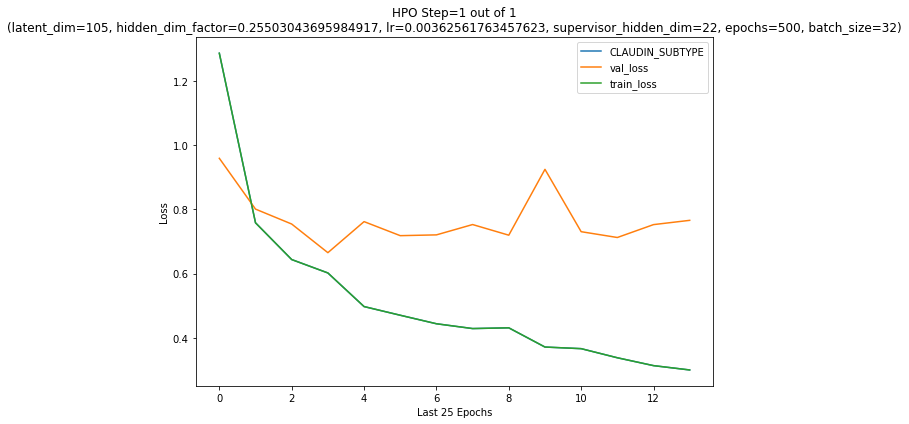

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      CLAUDIN_SUBTYPE      │    0.7655936479568481     │
│         val_loss          │    0.7655936479568481     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 1/1 [00:11<00:00, 11.99s/it, Iteration=1, Best Loss=0.766]

[INFO] current best val loss: 0.7655936479568481; best params: {'latent_dim': 105, 'hidden_dim_factor': 0.25503043695984917, 'lr': 0.00362561763457623, 'supervisor_hidden_dim': 22, 'epochs': 500, 'batch_size': 32} since 0 hpo iterations


In [15]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["CLAUDIN_SUBTYPE"],
                                        config_name = "DirectPred", 
                                        n_iter=1,  plot_losses=True, early_stop_patience=10) 
model, best_params = tuner.perform_tuning()

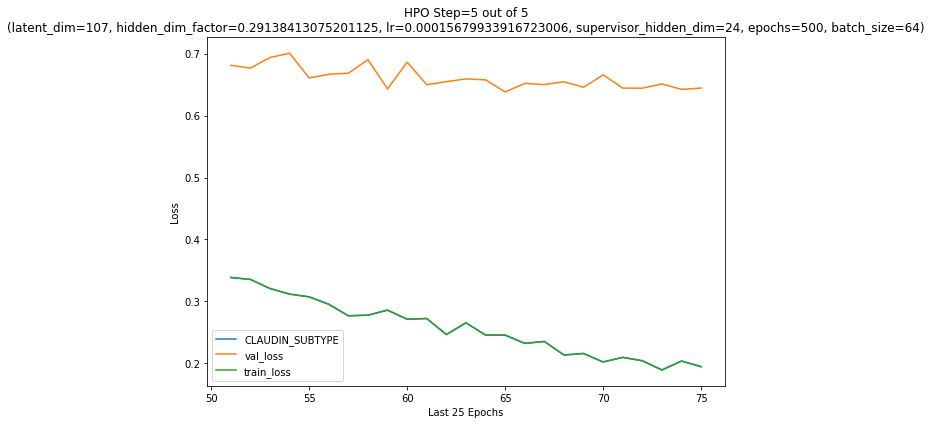

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      CLAUDIN_SUBTYPE      │    0.6444090604782104     │
│         val_loss          │    0.6444090604782104     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [02:04<00:00, 24.94s/it, Iteration=5, Best Loss=0.643]

[INFO] current best val loss: 0.643178403377533; best params: {'latent_dim': 32, 'hidden_dim_factor': 0.2876433945605655, 'lr': 0.0005404103854647327, 'supervisor_hidden_dim': 19, 'epochs': 500, 'batch_size': 64} since 2 hpo iterations


In [16]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["CLAUDIN_SUBTYPE"],
                                        config_name = "DirectPred", 
                                        n_iter=HPO_ITER, plot_losses=True,
                                        early_stop_patience=10)
model, best_params = tuner.perform_tuning()

In [17]:
model

DirectPred(
  (log_vars): ParameterDict(  (CLAUDIN_SUBTYPE): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=408, out_features=117, bias=True)
      (layer_out): Linear(in_features=117, out_features=32, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(117, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=450, out_features=129, bias=True)
      (layer_out): Linear(in_features=129, out_features=32, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (CLAUDIN_SUBTYPE): MLP(
      (layer_1): Linear(in_features=64, out_features=19, bias=True)
      (layer_out): Linear(in_features=19, out_features=7, bias=True)
      (relu

In [18]:
best_params

{'latent_dim': 32,
 'hidden_dim_factor': 0.2876433945605655,
 'lr': 0.0005404103854647327,
 'supervisor_hidden_dim': 19,
 'epochs': 36,
 'batch_size': 64}

In [19]:
y_pred_dict = model.predict(test_dataset)

In [20]:
y_pred_dict

{'CLAUDIN_SUBTYPE': array([[3.9017615e-03, 9.3903410e-04, 9.8527932e-01, ..., 9.7202079e-04,
         1.8079412e-03, 3.3722315e-03],
        [2.2883300e-02, 2.3537045e-02, 8.4334451e-01, ..., 1.3925167e-02,
         1.7120892e-02, 2.6951354e-02],
        [8.9181441e-01, 3.9944738e-02, 1.6782917e-02, ..., 5.0561647e-03,
         1.0243759e-02, 1.9195141e-02],
        ...,
        [4.5141433e-03, 1.2684659e-03, 9.7601706e-01, ..., 1.7744468e-03,
         3.2148887e-03, 6.6656307e-03],
        [1.9330133e-03, 4.0704686e-02, 5.2733808e-03, ..., 2.5480941e-03,
         5.1500490e-03, 3.2802968e-04],
        [1.1391262e-02, 7.7495232e-02, 2.9189698e-02, ..., 1.0723080e-02,
         4.6876293e-02, 5.4622265e-03]], dtype=float32)}

In [21]:
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)
metrics_df

,method,var,variable_type,metric,value
0,DirectPred,CLAUDIN_SUBTYPE,categorical,balanced_acc,0.586088
1,DirectPred,CLAUDIN_SUBTYPE,categorical,f1_score,0.743079
2,DirectPred,CLAUDIN_SUBTYPE,categorical,kappa,0.669797
3,DirectPred,CLAUDIN_SUBTYPE,categorical,average_auroc,0.929469
4,DirectPred,CLAUDIN_SUBTYPE,categorical,average_aupr,0.809056


In [22]:
ds = test_dataset
E = model.transform(ds)

In [23]:
E.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E54,E55,E56,E57,E58,E59,E60,E61,E62,E63
MB-5201,0.490522,0.166414,0.586126,-0.388294,-0.150096,-1.005129,-0.275688,-0.351930,0.569317,0.785017,...,-0.268728,0.796604,-0.642542,-0.390764,0.088388,-0.189291,0.258449,0.207026,-0.380375,-0.508520
MB-4691,-0.020828,0.465403,-0.448538,-0.322918,-0.348974,-0.817273,-0.150244,0.109829,0.267373,0.168967,...,-0.003928,0.144394,-0.074533,0.020477,-0.021652,-0.008336,-0.019815,0.154557,-0.125998,-0.042496
MB-3123,-0.856132,0.629006,0.497072,-0.534728,0.002602,-1.578417,0.297608,-0.107943,-0.718158,0.293418,...,-0.000948,0.305276,-0.116330,-0.182432,-0.102780,-0.059443,0.178256,0.145044,-0.370640,0.012924
MB-3102,0.189205,0.912911,-0.854123,0.384582,0.015680,-0.614281,-0.169980,-0.037017,-0.114318,0.240992,...,-0.115371,1.029114,-0.790962,-0.369143,0.368923,0.044219,0.325039,0.395249,-0.373274,-0.467165
MB-2744,-0.835248,1.069584,-0.220930,0.045327,-0.758907,-0.900341,0.277025,1.122083,-0.419388,0.080519,...,-0.451344,-0.090649,-0.198767,0.037984,-0.451520,-0.131028,0.093758,-0.121524,-0.491737,-0.115669


In [24]:
f = 'CLAUDIN_SUBTYPE'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

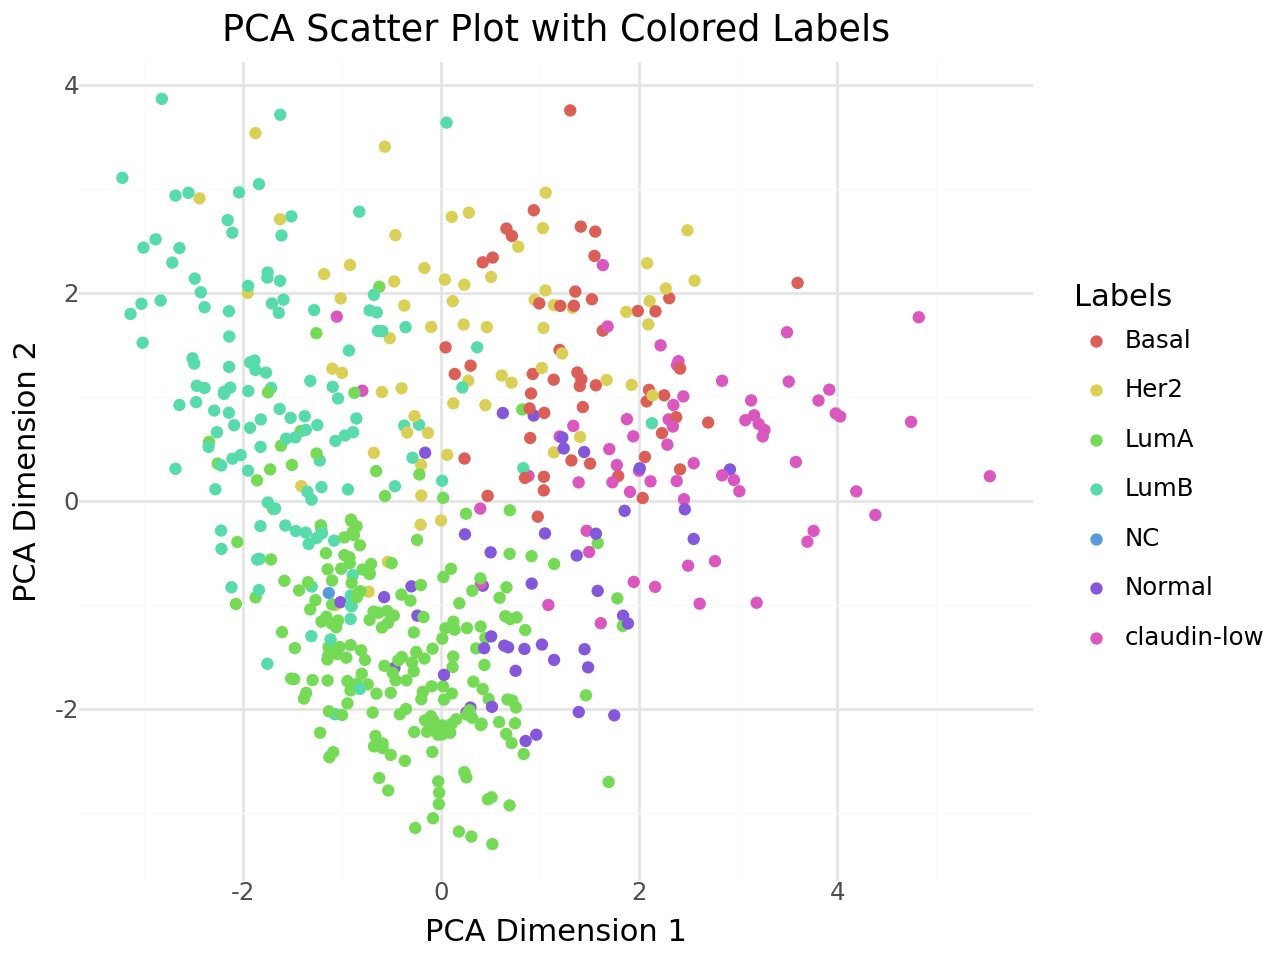

In [25]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='pca')

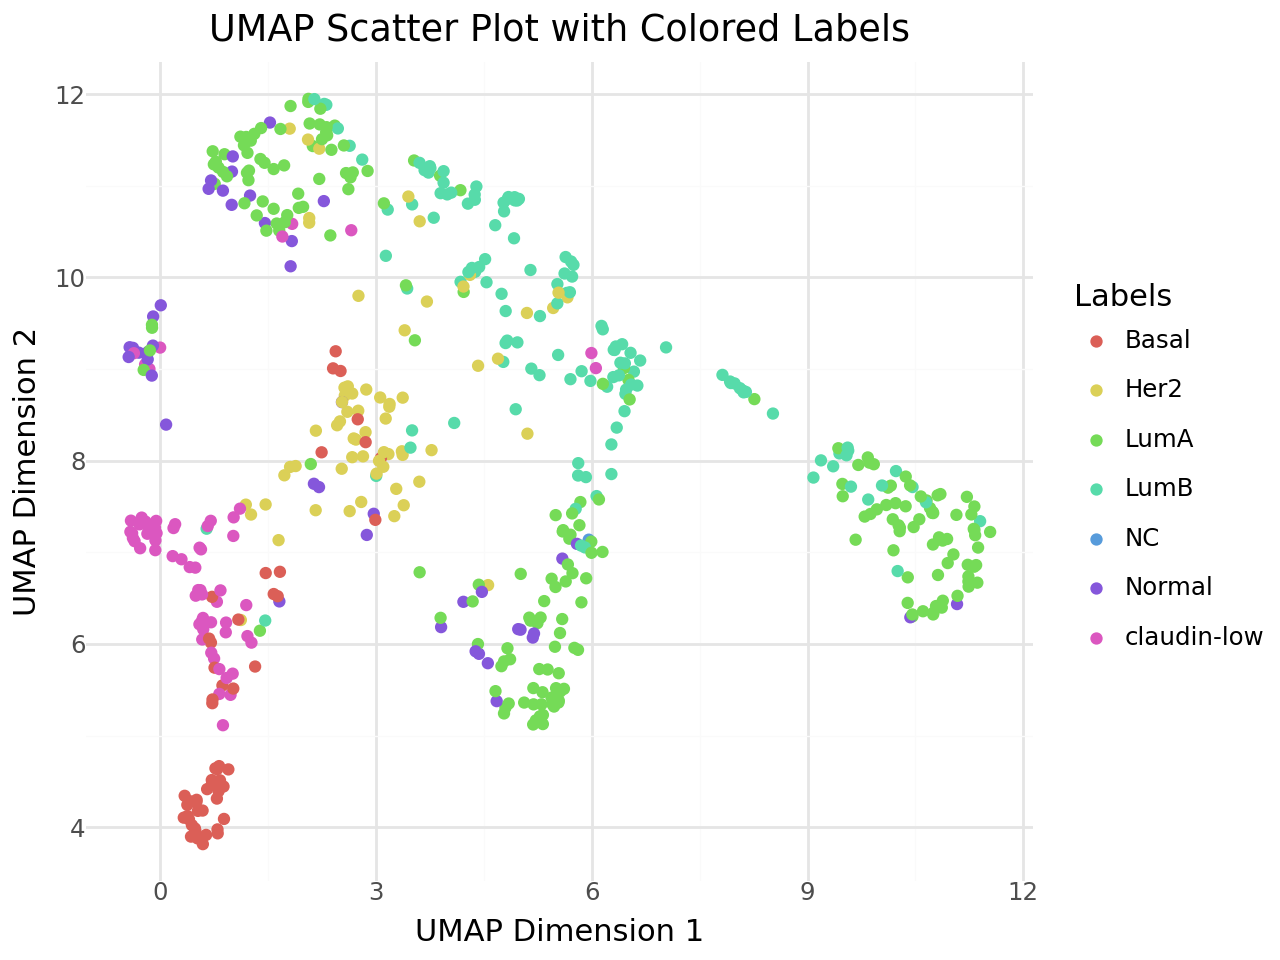

In [26]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')